# Imports

In [1]:
import os   # For path operations
import datetime

import hyperas
import tensorflow as tf
from tensorflow.python.client import device_lib

import numpy as np
import pandas as pd
import sklearn as sk
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten
from keras.optimizers import SGD
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.backend.tensorflow_backend import set_session
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from keras.models import load_model

import matplotlib.pyplot as plt

Using TensorFlow backend.


# Config GPU env

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
# Device check
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6009561756116083729
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3168377241
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12809102381777950446
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Def NN

## Training options (output type defined here)

In [3]:
#Change training mode between xyz or rot to define output type
training_mode = 'xyz'
patience=40
early_stopping=EarlyStopping(monitor = 'val_loss', patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath="CNN_weights_abs_test_"+training_mode+".hdf5", save_best_only=True, verbose =1)

## Create a 1D convnet based on the practice lesson for time series analysis

In [4]:
def make_1d_convnet(window_size, filter_length, nb_input_series=1, nb_outputs=1,nb_filter=4):
    model = Sequential()
    # Defining input shape of the first layer based on desired output type
    model.add(Conv1D(filters = nb_filter, kernel_size = filter_length, activation = 'relu', 
                    input_shape = (window_size,nb_input_series)))
    model.add(MaxPooling1D())
    model.add(Conv1D(filters = nb_filter, kernel_size = filter_length, activation = 'relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(100,activation = 'linear'))
    model.add(Dense(nb_outputs,activation = 'linear'))
    model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    return model

## Create input and output format from raw data

In [5]:
def make_timeseries_instances(out_type,timeseries, window_size, nb_inputs):
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0] , "Out of range 0 < {} < {}".format(window_size,timeseries.shape[0])
    # nb_input defines the number of input time series that we use to predict outputs
    if out_type == 'xyz':
        X = np.atleast_3d(np.array([timeseries[start:start+window_size,:nb_inputs] for start in range(0,timeseries.shape[0]-window_size)]))
        for coord in range(3):
            np.roll(X[:,coord + 10],1) # Move xyz coordinates to the past
        np.delete(X,0,0)
    
        # We have 3 output signal: x, y and z position    
        y = timeseries[window_size:,-11:-8]
        np.delete(y,0,0)
        
    if out_type == 'rot':
        temp_arr=timeseries[:, np.r_[:10, 14:18]] # Load sensor data and orientation reference to input
        X = np.atleast_3d(np.array([temp_arr[start:start+window_size,:nb_inputs] for start in range(0,temp_arr.shape[0]-window_size)]))
        for coord in range(4):
            np.roll(X[:,coord + 10],1) # Move orientation coordinates to the past
        np.delete(X,0,0)
    
        # We have 4 output signal: Qx, Qy, Qz and Qw orientation    
        y = timeseries[window_size:,-7:-3]
        np.delete(y,0,0)
        
    return X,y

## Train the network on timeseries

In [6]:
def evalute_timeseries(out_type,timeseries, window_size, filter_length, nb_filter, epochs, batch_size):
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T
    nb_samples, nb_series = timeseries.shape
    
    # Define in and output size based on output type
    if out_type == 'xyz':
        nb_inputs = nb_series - 8 # Only 13 inputs (previous x,y,z position is an input now)
        nb_outputs = 3
    if out_type == 'rot':
        nb_inputs = nb_series - 7 # Only 14 inputs (previous Qx,Qy,Qz and Qw orientation is an input now)
        nb_outputs = 4
        
    # Initialize model
    model= make_1d_convnet(window_size=window_size, filter_length=filter_length, nb_input_series=nb_inputs,
                        nb_outputs=nb_outputs,nb_filter=nb_filter)
    model.summary()
  
    # Fill and split the input and output variables
    X,y = make_timeseries_instances(out_type,timeseries, window_size,nb_inputs=nb_inputs)
  
    test_size = int(0.3  * nb_samples)
    valid_size = int(0.2 * nb_samples)
    X_train, X_valid, X_test = X[:-(test_size+valid_size),:], X[-(test_size+valid_size):-test_size,:], X[-test_size:,:]
    y_train, y_valid, y_test = y[:-(test_size+valid_size),:], y[-(test_size+valid_size):-test_size,:], y[-test_size:,:]
    
    # Train model
    model.fit(X_train,y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_valid, y_valid),
              verbose = 2, callbacks = [checkpointer,early_stopping])
  
    # Load the best model for plotting
    bestmodel = load_model("CNN_weights_abs_test_"+out_type+".hdf5")
    preds = bestmodel.predict(X_test)
    targets = y_test
    
    # Plot the results based on output type
    if out_type == 'xyz':
        # Plot predicted x vs target x
        plt.figure(0)
        plt.plot(preds[:,0],color = 'green', label = 'x pred')
        plt.plot(targets[:,0],color = 'red', label = 'x targ')
    
        # Plot predicted z vs target z
        plt.figure(1)
        plt.plot(preds[:,2],color = 'blue', label = 'z pred')
        plt.plot(targets[:,2],color = 'yellow', label = 'z targ')
    
        # Plot the predicted route vs original route on x-z plane
        plt.figure(2)
        plt.plot(preds[:,0],preds[:,2], label = 'xz pred')
        plt.plot(targets[:,0],targets[:,2], label = 'xz targ')
        
    if out_type == 'rot':
        plt.figure(0,figsize = (15,5))
        plt.plot(preds[:,0],color = 'red', label = 'Qx pred')
        plt.plot(targets[:,0],color = 'green', label = 'Qx targ')
        
        plt.figure(1,figsize = (15,5))
        plt.plot(preds[:,1],color = 'red', label = 'Qy pred')
        plt.plot(targets[:,1],color = 'green', label = 'Qy targ')
        
        plt.figure(2,figsize = (15,5))
        plt.plot(preds[:,2],color = 'red', label = 'Qz pred')
        plt.plot(targets[:,2],color = 'green', label = 'Qz targ')
        
        plt.figure(3,figsize = (15,5))
        plt.plot(preds[:,3],color = 'red', label = 'Qw pred')
        plt.plot(targets[:,3],color = 'green', label = 'Qw targ')

# Load data file

In [7]:
df = pd.read_csv('Bazs\\PreprocessedData_v3.txt',
                               sep='\t',
                               decimal=',')
header = df.columns
df_arr =np.array(df, dtype='float64')
df =pd.DataFrame(df_arr, columns=header)

In [8]:
df.head(2)

,delta_t,acc0,acc1,acc2,gyro0,gyro1,gyro2,mag0,mag1,mag2,...,y,z,beta,Qx,Qy,Qz,Qw,delta_x,delta_y,delta_z
0,0.0000,-0.0029,0.0003,-0.0003,-0.0194,0.0124,-0.0022,-0.5292,-0.6538,-0.5275,...,0.221,0.402,-0.0129,0.005,0.02,0.000,1.0,0.0,0.0,0.0
1,0.0891,-0.0029,0.0013,0.0007,-0.0085,0.0023,0.0006,-0.5292,-0.6538,-0.4945,...,0.221,0.402,-0.0128,0.005,0.02,0.001,1.0,0.0,0.0,0.0


# Set hyperparameters

In [9]:
#1D convolution
window_size = 20
filter_length = 5
nb_filter = 4

#Train config
epochs = 400
batch_size = 16
validation_split = 0.2

# Train NN

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 16, 4)             264       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 4)              0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4, 4)              84        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 4)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               900       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total para


Epoch 00036: val_loss did not improve from 0.00468
Epoch 37/400
 - 1s - loss: 3.3731e-04 - mean_absolute_error: 0.0130 - val_loss: 0.0057 - val_mean_absolute_error: 0.0427

Epoch 00037: val_loss did not improve from 0.00468
Epoch 38/400
 - 1s - loss: 3.2856e-04 - mean_absolute_error: 0.0128 - val_loss: 0.0051 - val_mean_absolute_error: 0.0368

Epoch 00038: val_loss did not improve from 0.00468
Epoch 39/400
 - 1s - loss: 3.0811e-04 - mean_absolute_error: 0.0123 - val_loss: 0.0050 - val_mean_absolute_error: 0.0344

Epoch 00039: val_loss did not improve from 0.00468
Epoch 40/400
 - 1s - loss: 2.9512e-04 - mean_absolute_error: 0.0119 - val_loss: 0.0046 - val_mean_absolute_error: 0.0334

Epoch 00040: val_loss improved from 0.00468 to 0.00464, saving model to CNN_weights_abs_test_xyz.hdf5
Epoch 41/400
 - 1s - loss: 2.8231e-04 - mean_absolute_error: 0.0119 - val_loss: 0.0044 - val_mean_absolute_error: 0.0314

Epoch 00041: val_loss improved from 0.00464 to 0.00439, saving model to CNN_weights


Epoch 00082: val_loss did not improve from 0.00334
Epoch 83/400
 - 1s - loss: 1.3404e-04 - mean_absolute_error: 0.0077 - val_loss: 0.0045 - val_mean_absolute_error: 0.0321

Epoch 00083: val_loss did not improve from 0.00334
Epoch 84/400
 - 1s - loss: 1.4808e-04 - mean_absolute_error: 0.0082 - val_loss: 0.0041 - val_mean_absolute_error: 0.0316

Epoch 00084: val_loss did not improve from 0.00334
Epoch 85/400
 - 1s - loss: 1.4104e-04 - mean_absolute_error: 0.0079 - val_loss: 0.0047 - val_mean_absolute_error: 0.0335

Epoch 00085: val_loss did not improve from 0.00334
Epoch 86/400
 - 1s - loss: 1.7185e-04 - mean_absolute_error: 0.0089 - val_loss: 0.0045 - val_mean_absolute_error: 0.0327

Epoch 00086: val_loss did not improve from 0.00334
Epoch 87/400
 - 1s - loss: 1.4817e-04 - mean_absolute_error: 0.0084 - val_loss: 0.0052 - val_mean_absolute_error: 0.0365

Epoch 00087: val_loss did not improve from 0.00334
Epoch 88/400
 - 1s - loss: 1.5601e-04 - mean_absolute_error: 0.0085 - val_loss: 0.0

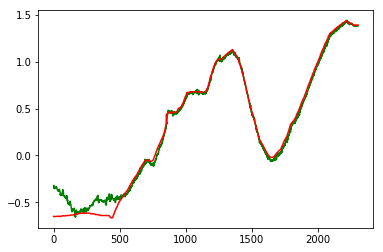

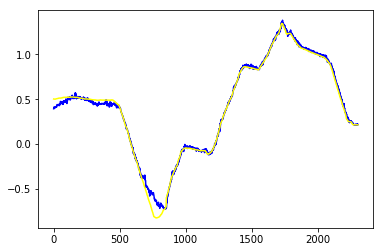

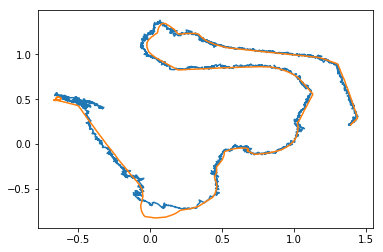

In [10]:
#use 'xyz' or 'rot' to choose output
evalute_timeseries(training_mode,df,window_size,filter_length,nb_filter, epochs, batch_size)

# Draw prediction with the model (previous pos or rot is the reference data)

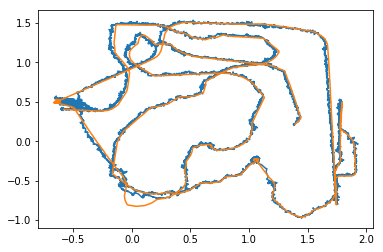

In [11]:
# Predict with reference dataset
if training_mode == 'xyz':
    X,y = make_timeseries_instances(training_mode,df, window_size,nb_inputs=13)
if  training_mode == 'rot':
    X,y = make_timeseries_instances(training_mode,df, window_size,nb_inputs=14)
model = load_model("CNN_weights_abs_test_"+training_mode+".hdf5")
y_pred = model.predict(X)

if training_mode == 'xyz':
    plt.figure(0)
    plt.plot(y_pred[:,0],y_pred[:,2], label='xz pred')
    plt.plot(y[:,0],y[:,2], label='xz targ')
    
if  training_mode == 'rot':
    plt.figure(0,figsize = (15,5))
    plt.plot(y_pred[:,0],color = 'red', label = 'Qx pred')
    plt.plot(y[:,0],color = 'green', label = 'Qx targ')
        
    plt.figure(1,figsize = (15,5))
    plt.plot(y_pred[:,1],color = 'red', label = 'Qy pred')
    plt.plot(y[:,1],color = 'green', label = 'Qy targ')
        
    plt.figure(2,figsize = (15,5))
    plt.plot(y_pred[:,2],color = 'red', label = 'Qz pred')
    plt.plot(y[:,2],color = 'green', label = 'Qz targ')
        
    plt.figure(3,figsize = (15,5))
    plt.plot(y_pred[:,3],color = 'red', label = 'Qw pred')
    plt.plot(y[:,3],color = 'green', label = 'Qw targ')

# Draw prediction with the model (previous pos or rot is predicted)

(7658, 20, 13)
(7658, 3)


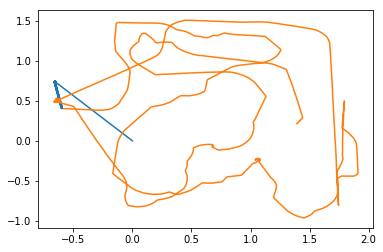

In [12]:
# Predict with calculated data
newX=X
newy_pred=np.empty(y.shape)
print(newX.shape)
print(y.shape)

if  training_mode == 'xyz':
    for index in range(y.shape[0]-1):
        if index > 0:
            temp=newX[index,-1]
            newX[index]=np.roll(newX[index-1],-1, axis=0)
            newX[index,-1]=temp
            for coord in range(3):  
                newX[index,-1,coord+10]=newy_pred[index-1,coord]
        tmp=np.empty((1,20,13))
        tmp[0]=newX[index]
        newy_pred[index]=model.predict(tmp)
    
    plt.figure(0)
    plt.plot(newy_pred[:,0],newy_pred[:,2], label='xz pred')
    plt.plot(y[:,0],y[:,2], label='xz targ')

if  training_mode == 'rot':
    for index in range(y.shape[0]-1):
        if index > 0:
            temp=newX[index,-1]
            newX[index]=np.roll(newX[index-1],-1, axis=0)
            newX[index,-1]=temp
            for coord in range(4):  
                newX[index,-1,coord+10]=newy_pred[index-1,coord]
        tmp=np.empty((1,20,14))
        tmp[0]=newX[index]
        newy_pred[index]=model.predict(tmp)
    
    plt.figure(0,figsize = (15,5))
    plt.plot(newy_pred[:,0],color = 'red', label = 'Qx pred')
    plt.plot(y[:,0],color = 'green', label = 'Qx targ')
        
    plt.figure(1,figsize = (15,5))
    plt.plot(newy_pred[:,1],color = 'red', label = 'Qy pred')
    plt.plot(y[:,1],color = 'green', label = 'Qy targ')
        
    plt.figure(2,figsize = (15,5))
    plt.plot(newy_pred[:,2],color = 'red', label = 'Qz pred')
    plt.plot(y[:,2],color = 'green', label = 'Qz targ')
        
    plt.figure(3,figsize = (15,5))
    plt.plot(newy_pred[:,3],color = 'red', label = 'Qw pred')
    plt.plot(y[:,3],color = 'green', label = 'Qw targ')

Something fishy here... 